# SSY340 Project - Trajectory Estimation

### Fill in group number and member names:

In [1]:
NAME1 = "Bingcheng Chen" 
NAME2 = "Arvin Rokni"
GROUP = "Project groups 64"

## 1. Loading the data

In [7]:
import torch
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np
import os
import dataloader
import model_cbc
import utils
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

## 2. Pre-processing

In [8]:
# defining model save location
save_location = "./models"
# defining dataset locations
dataset_folder = "./trajectory-prediction-transformers/datasets"
dataset_name = "raw"
# setting validation size. if val_size = 0, split percentage is 80-20
val_size = 0
# length of sequence given to encoder
gt = 8
# length of sequence given to decoder
horizon = 12


train_dataset, _ = dataloader.create_dataset(dataset_folder, dataset_name, val_size, \
    gt, horizon, delim="\t", train=True)
val_dataset, _ = dataloader.create_dataset(dataset_folder, dataset_name, val_size, \
    gt, horizon, delim="\t", train=False)
# test_dataset, _ = dataloader.create_dataset(dataset_folder, dataset_name, val_size, \
#     gt, horizon, delim="\t", train=False, eval=True)

In [9]:
val_dataset[10]

{'src': tensor([[ 4.9693e+00,  8.3395e+00,  0.0000e+00,  0.0000e+00],
         [ 5.1330e+00,  8.3350e+00,  1.6374e-01, -4.5338e-03],
         [ 5.2968e+00,  8.3307e+00,  1.6374e-01, -4.2963e-03],
         [ 5.3915e+00,  8.3490e+00,  9.4709e-02,  1.8377e-02],
         [ 5.4565e+00,  8.3774e+00,  6.5034e-02,  2.8400e-02],
         [ 5.5218e+00,  8.4058e+00,  6.5244e-02,  2.8400e-02],
         [ 5.5868e+00,  8.4342e+00,  6.5033e-02,  2.8400e-02],
         [ 5.5988e+00,  8.4497e+00,  1.1997e-02,  1.5512e-02]]),
 'trg': tensor([[ 5.5575e+00,  8.4521e+00, -4.1251e-02,  2.3870e-03],
         [ 5.5163e+00,  8.4548e+00, -4.1251e-02,  2.6255e-03],
         [ 5.4750e+00,  8.4571e+00, -4.1251e-02,  2.3861e-03],
         [ 5.4340e+00,  8.4595e+00, -4.1041e-02,  2.3870e-03],
         [ 5.3927e+00,  8.4622e+00, -4.1251e-02,  2.6245e-03],
         [ 5.3515e+00,  8.4645e+00, -4.1251e-02,  2.3870e-03],
         [ 5.3102e+00,  8.4669e+00, -4.1251e-02,  2.3861e-03],
         [ 5.2690e+00,  8.4696e+00, -4.

In [10]:
val_dataset[10]['src'].shape

torch.Size([8, 4])

## 3. Data loaders

In [11]:
# defining batch size
batch_size = 64

# creating torch dataloaders
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size, shuffle=True, num_workers=0)

In [12]:
# calculating the mean and standard deviation of velocities of the entire dataset
mean = torch.cat((train_dataset[:]['src'][:, 1:, 2:4],
                    train_dataset[:]['trg'][:, :, 2:4]), 1).mean((0, 1))
std = torch.cat((train_dataset[:]['src'][:, 1:, 2:4],
                train_dataset[:]['trg'][:, :, 2:4]), 1).std((0, 1))
means = []
stds = []
for i in np.unique(train_dataset[:]['dataset']):
    ind = train_dataset[:]['dataset'] == i
    means.append(torch.cat(
        (train_dataset[:]['src'][ind, 1:, 2:4], train_dataset[:]['trg'][ind, :, 2:4]), 1).mean((0, 1)))
    stds.append(
        torch.cat((train_dataset[:]['src'][ind, 1:, 2:4], train_dataset[:]['trg'][ind, :, 2:4]), 1).std((0, 1)))
mean = torch.stack(means).mean(0)
std = torch.stack(stds).mean(0)

## 4. Training

#### 4.1 create a model

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

tf_model = model_cbc.Transformer(encoder_input_size=2, decoder_input_size=3,
                                embedding_size=512, num_heads=8, num_layers=6, feedforward_size=2048)

In [14]:
tf_model

Transformer(
  (encoder_embedding): Embeddings(
    (linear_embd): Linear(in_features=2, out_features=512, bias=True)
  )
  (decoder_embedding): Embeddings(
    (linear_embd): Linear(in_features=3, out_features=512, bias=True)
  )
  (positional_encoding): PositionalEncoding()
  (encoder_layers): ModuleList(
    (0-5): 6 x EncoderLayer(
      (self_attn): MultiHeadAttention(
        (W_q): Linear(in_features=512, out_features=512, bias=True)
        (W_k): Linear(in_features=512, out_features=512, bias=True)
        (W_v): Linear(in_features=512, out_features=512, bias=True)
        (W_o): Linear(in_features=512, out_features=512, bias=True)
      )
      (feed_forward): PositionWiseFeedForward(
        (fc1): Linear(in_features=512, out_features=2048, bias=True)
        (fc2): Linear(in_features=2048, out_features=512, bias=True)
        (relu): ReLU()
      )
      (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((512,), eps=1e-05, elementwise_af

#### 4.2 The training loop

In [15]:
iterations = 70

# creating optimizer
optimizer = torch.optim.SGD(tf_model.parameters(
), lr=1e-4, momentum=0.9, weight_decay=1e-3, nesterov=True)
# optimizer = torch.optim.Adam(tf_model.parameters(), lr=1e-4)

train_loss, learning_rates = utils.learning_rate_finder(
    tf_model, optimizer, train_loader, iterations, device, mean, std)
eta_star = learning_rates[np.argmin(np.array(train_loss))]
eta_max = eta_star/10
print("Value of eta max is: {:.4f}".format(eta_max))

# plotting results
# plt.figure()
# plt.plot(learning_rates, train_loss)
# plt.xlabel("Learning rates")
# plt.ylabel("Training loss")
# plt.xscale('log')
# plt.title("Learning Rate Finder Algorithm")
# plt.show()

# number of epochs
epochs = 1

# metric variables
training_loss = []
validation_loss = []
val_mad = []
val_fad = []

# finding the total number of weight updates for the network
T = epochs * len(train_loader)
# initializing variable to track the number of weight updates
weight_update = 0
# initializing variable to store the changing learning rate
learning_rate = []

for epoch in tqdm(range(epochs)):
    # TRAINING MODE
    tf_model.train()

    # training batch variables
    train_batch_loss = 0

    for idx, data in enumerate(train_loader):
        # changing the learning rate based on cosine scheduler
        lr = utils.cosine_scheduler(weight_update, eta_max, T)
        for param in optimizer.param_groups:
            learning_rate.append(lr)
            param['lr'] = lr
        weight_update += 1

        # getting encoder input data
        # (64, 7, 512)
        enc_input = (data['src'][:, 1:, 2:4].to(
            device)-mean.to(device))/std.to(device)

        # getting decoder input data
        target = (data['trg'][:, :-1, 2:4].to(device) -
                    mean.to(device))/std.to(device)
        target_append = torch.zeros(
            (target.shape[0], target.shape[1], 1)).to(device)
        target = torch.cat((target, target_append), -1)
        start_of_seq = torch.Tensor([0, 0, 1]).unsqueeze(
            0).unsqueeze(1).repeat(target.shape[0], 1, 1).to(device)
        (64, 12, 512)
        dec_input = torch.cat((start_of_seq, target), 1)

        # getting masks for decoder
        dec_source_mask = torch.ones(
            (enc_input.shape[0], 1, enc_input.shape[1])).to(device)
        dec_target_mask = utils.subsequent_mask(
            dec_input.shape[1]).repeat(dec_input.shape[0], 1, 1).to(device)

        # forward pass
        optimizer.zero_grad()
        # predictions = tf_model.forward(enc_input, dec_input, dec_source_mask, dec_target_mask)
        predictions = tf_model.forward(enc_input, dec_input)

        # calculating loss using pairwise distance of all predictions
        loss = F.pairwise_distance(predictions[:, :, 0:2].contiguous().view(-1, 2),
                                    ((data['trg'][:, :, 2:4].to(device)-mean.to(device))/std.to(device)).
                                    contiguous().view(-1, 2).to(device)).mean() + \
            torch.mean(torch.abs(predictions[:, :, 2]))
        train_batch_loss += loss.item()

        # updating weights
        loss.backward()
        optimizer.step()

    training_loss.append(train_batch_loss/len(train_loader))
    print("Epoch {}/{}....Training loss = {:.4f}".format(epoch +
            1, epochs, training_loss[-1]))

    # validation loop
    if (epoch+1) % 5 == 0:
        with torch.no_grad():
            # EVALUATION MODE
            tf_model.eval()

            # validation variables
            batch_val_loss = 0
            gt = []
            pr = []

            for id_b, data in enumerate(val_loader):
                # storing groung truth
                gt.append(data['trg'][:, :, 0:2])

                # input to encoder input
                val_input = (data['src'][:, 1:, 2:4].to(
                    device)-mean.to(device))/std.to(device)

                # input to decoder
                start_of_seq = torch.Tensor([0, 0, 1]).unsqueeze(0).unsqueeze(
                    1).repeat(val_input.shape[0], 1, 1).to(device)
                dec_inp = start_of_seq
                # decoder masks
                dec_source_mask = torch.ones(
                    (val_input.shape[0], 1, val_input.shape[1])).to(device)
                dec_target_mask = utils.subsequent_mask(
                    dec_inp.shape[1]).repeat(dec_inp.shape[0], 1, 1).to(device)

                # prediction till horizon lenght
                for i in range(horizon):
                    # getting model prediction
                    # model_output = tf_model.forward(val_input, dec_inp, dec_source_mask, dec_target_mask)
                    model_output = tf_model.forward(val_input, dec_inp)

                    # appending the predicition to decoder input for next cycle
                    dec_inp = torch.cat(
                        (dec_inp, model_output[:, -1:, :]), 1)

                # calculating loss using pairwise distance of all predictions
                val_loss = F.pairwise_distance(dec_inp[:, 1:, 0:2].contiguous().view(-1, 2),
                                                ((data['trg'][:, :, 2:4].to(device)-mean.to(device))/std.to(device)).
                                                contiguous().view(-1, 2).to(device)).mean() + \
                    torch.mean(torch.abs(dec_inp[:, 1:, 2]))
                batch_val_loss += val_loss.item()

                # calculating the position for each time step of prediction based on velocity
                preds_tr_b = (dec_inp[:, 1:, 0:2]*std.to(device) + mean.to(device)).cpu().numpy().cumsum(1) + \
                    data['src'][:, -1:, 0:2].cpu().numpy()

                pr.append(preds_tr_b)
            validation_loss.append(batch_val_loss/len(val_loader))

            # calculating mad and fad evaluation metrics
            gt = np.concatenate(gt, 0)
            pr = np.concatenate(pr, 0)
            mad, fad, _ = dataloader.distance_metrics(gt, pr)
            val_mad.append(mad)
            val_fad.append(fad)

            print("Epoch {}/{}....Validation mad = {:.4f}, Validation fad = {:.4f}".format(
                epoch+1, epochs, mad, fad))

    # Saving model, loss and error log files
    torch.save({
        'model_state_dict': tf_model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'training_loss': training_loss,
        'validation_loss': validation_loss,
        'val_mad': val_mad,
        'val_fad': val_fad,
        'learning_rate': learning_rate
    }, os.path.join(save_location, 'epoch{}.pth'.format(epoch+1)))


Value of eta max is: 0.0000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/1....Training loss = 10.9543


100%|██████████| 1/1 [03:53<00:00, 233.78s/it]


## 5. Visualisation

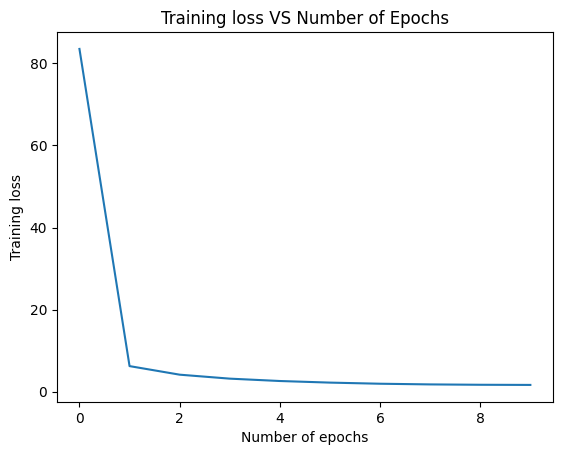

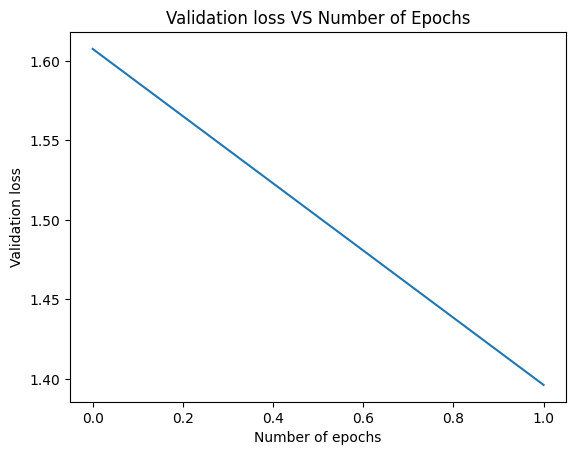

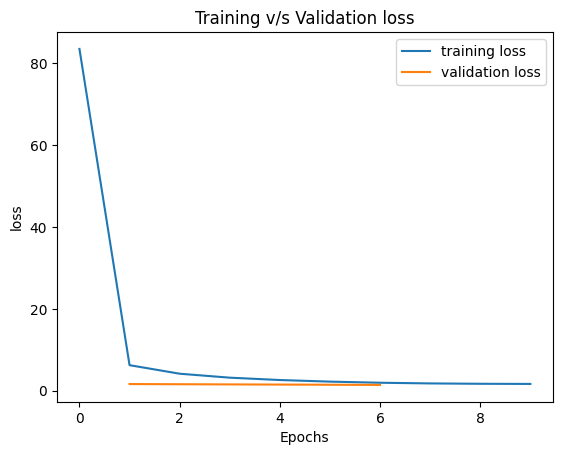

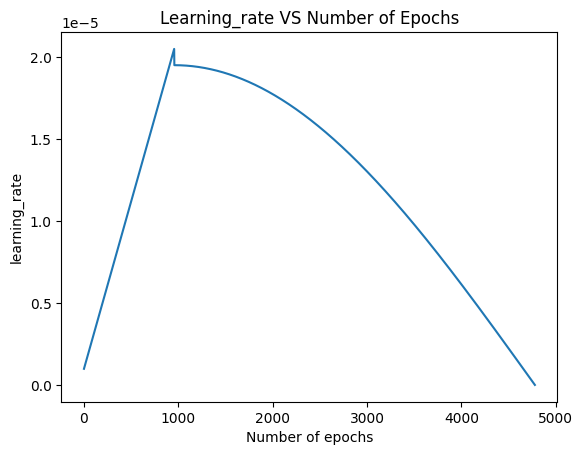

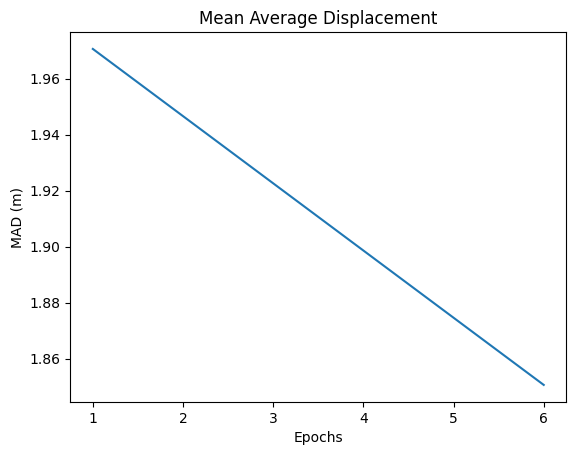

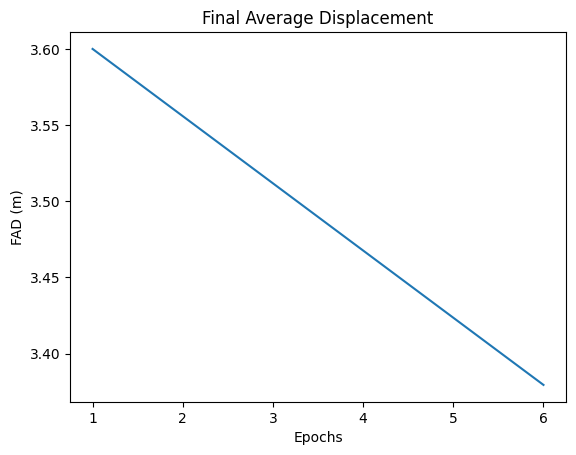

In [21]:
device = "cuda" if torch.cuda.is_available() else "cpu"
loaded_file = torch.load(os.path.join(
    save_location, 'epoch10.pth'), map_location=torch.device(device))

# creating model and loading weights
# encoder_ip_size = 2
# decoder_ip_size = 3
# model_op_size = 3
# emb_size = 512
# num_heads = 8
# ff_hidden_size = 2048
# n = 6
# dropout = 0.1

# model_loaded = model.TFModel(encoder_ip_size, decoder_ip_size, model_op_size, emb_size,
#                              num_heads, ff_hidden_size, n, dropout=0.1)

model_loaded = model_cbc.Transformer(encoder_input_size=2, decoder_input_size=3,
                                embedding_size=512, num_heads=8, num_layers=6, feedforward_size=2048)


model_loaded = model_loaded.to(device)
model_loaded.load_state_dict(loaded_file['model_state_dict'])

# loading training metric variables
training_loss = loaded_file['training_loss']
validation_loss = loaded_file['validation_loss']
val_mad = loaded_file['val_mad']
val_fad = loaded_file['val_fad']
learning_rate = loaded_file['learning_rate']

# plotting training loss
plt.figure()
plt.plot(training_loss)
plt.xlabel("Number of epochs")
plt.ylabel("Training loss")
plt.title("Training loss VS Number of Epochs")

# plotting validation loss
plt.figure()
plt.plot(validation_loss)
plt.xlabel("Number of epochs")
plt.ylabel("Validation loss")
plt.title("Validation loss VS Number of Epochs")

# plotting training and validation loss together
plt.figure()
plt.plot(loaded_file['training_loss'], label="training loss")
plt.plot(np.arange(1, 10, 5),
            loaded_file['validation_loss'], label="validation loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.title("Training v/s Validation loss")
plt.savefig("loss.png")

# plotting learning rate for model
plt.figure()
plt.plot(learning_rate)
plt.xlabel("Number of epochs")
plt.ylabel("learning_rate")
plt.title("Learning_rate VS Number of Epochs")

# plotting MAD
plt.figure()
plt.plot(np.arange(1, 10, 5),
            loaded_file['val_mad'], label="validation MAD")
plt.xlabel("Epochs")
plt.ylabel("MAD (m)")
plt.title("Mean Average Displacement")
plt.savefig("mad.png")

# plotting FAD
plt.figure()
plt.plot(np.arange(1, 10, 5),
            loaded_file['val_fad'], label="validation FAD")
plt.xlabel("Epochs")
plt.ylabel("FAD (m)")
plt.title("Final Average Displacement")
plt.savefig("fad.png")

plt.show()

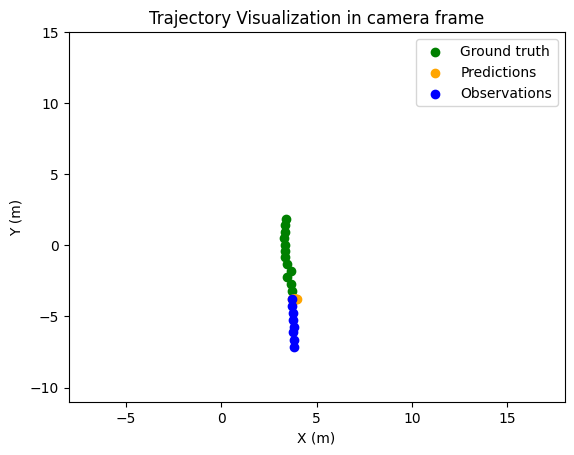

In [23]:
# Running the validation loop to generate prediction trajectories on validation data
validation_loss = []
val_mad = []
val_fad = []

with torch.no_grad():
    # EVALUATION MODE
    model_loaded.eval()

    # validation variables
    batch_val_loss = 0
    gt = []
    pr = []
    obs = []

    for id_b, data in enumerate(val_loader):
        # storing groung truth
        gt.append(data['trg'][:, :, 0:2])
        obs.append(data['src'][:, :, 0:2])
        # input to encoder input
        val_input = (data['src'][:, 1:, 2:4].to(
            device)-mean.to(device))/std.to(device)

        # input to decoder
        start_of_seq = torch.Tensor([0, 0, 1]).unsqueeze(0).unsqueeze(
            1).repeat(val_input.shape[0], 1, 1).to(device)
        dec_inp = start_of_seq
        # decoder masks
        dec_source_mask = torch.ones(
            (val_input.shape[0], 1, val_input.shape[1])).to(device)
        dec_target_mask = utils.subsequent_mask(
            dec_inp.shape[1]).repeat(dec_inp.shape[0], 1, 1).to(device)

        # prediction till horizon lenght
        for i in range(horizon):
            # getting model prediction
            # model_output = model_loaded.forward(
            #     val_input, dec_inp, dec_source_mask, dec_target_mask)

            model_output = model_loaded.forward(val_input, dec_inp)

            # appending the predicition to decoder input for next cycle
            dec_inp = torch.cat((dec_inp, model_output[:, -1:, :]), 1)

        # calculating loss using pairwise distance of all predictions
        val_loss = F.pairwise_distance(dec_inp[:, 1:, 0:2].contiguous().view(-1, 2),
                                        ((data['trg'][:, :, 2:4].to(device)-mean.to(device))/std.to(device)).
                                        contiguous().view(-1, 2).to(device)).mean() + \
            torch.mean(torch.abs(dec_inp[:, 1:, 2]))
        batch_val_loss += val_loss.item()

        # calculating the position for each time step of prediction based on velocity
        preds_tr_b = (dec_inp[:, 1:, 0:2]*std.to(device) + mean.to(device)).cpu().numpy().cumsum(1) + \
            data['src'][:, -1:, 0:2].cpu().numpy()

        pr.append(preds_tr_b)
        validation_loss.append(batch_val_loss/len(val_loader))

    # calculating mad and fad evaluation metrics
    gt = np.concatenate(gt, 0)
    pr = np.concatenate(pr, 0)
    obs = np.concatenate(obs, 0)
    mad, fad, _ = dataloader.distance_metrics(gt, pr)
    val_mad.append(mad)
    val_fad.append(fad)

# plotting the predicted and ground truth trajectories
idx = np.random.randint(0, gt.shape[0])
plt.figure()
plt.scatter(gt[idx, :, 0], gt[idx, :, 1],
            color='green', label="Ground truth")
plt.scatter(pr[idx, :, 0], pr[idx, :, 1],
            color='orange', label="Predictions")
plt.scatter(obs[idx, :, 0], obs[idx, :, 1],
            color='b', label="Observations")
plt.legend()
plt.xlim(-8, 18)
plt.ylim(-11, 15)
plt.title("Trajectory Visualization in camera frame")
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.savefig("traj_{}".format(idx))

plt.show()

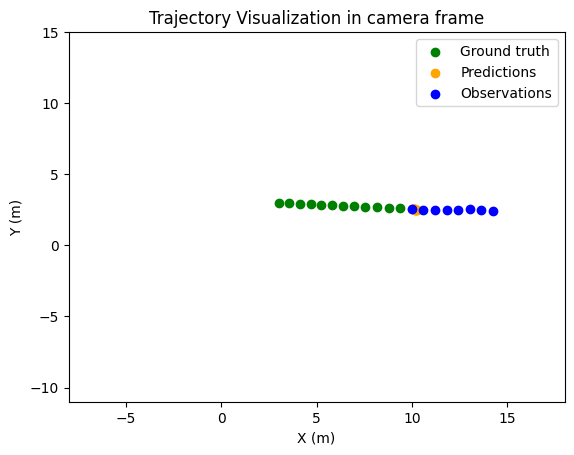

In [25]:
# plotting the predicted and ground truth trajectories
idx = np.random.randint(0, gt.shape[0])
plt.figure()
plt.scatter(gt[idx, :, 0], gt[idx, :, 1],
            color='green', label="Ground truth")
plt.scatter(pr[idx, :, 0], pr[idx, :, 1],
            color='orange', label="Predictions")
plt.scatter(obs[idx, :, 0], obs[idx, :, 1],
            color='b', label="Observations")
plt.legend()
plt.xlim(-8, 18)
plt.ylim(-11, 15)
plt.title("Trajectory Visualization in camera frame")
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.savefig("traj_{}".format(idx))

plt.show()

In [28]:
gt[idx, :, 0]

array([9.3886385, 8.781236 , 8.173834 , 7.566431 , 6.9592395, 6.3823543,
       5.818729 , 5.255103 , 4.691688 , 4.1280627, 3.5644372, 3.0155442],
      dtype=float32)

In [26]:
pr[idx, :, 0]

array([10.017094 , 10.03837  , 10.059654 , 10.080941 , 10.102231 ,
       10.123523 , 10.144815 , 10.166111 , 10.187407 , 10.208703 ,
       10.2300005, 10.251298 ], dtype=float32)

In [27]:
pr[idx, :, 1]

array([2.5474253, 2.5433333, 2.539239 , 2.5351436, 2.531047 , 2.5269501,
       2.5228524, 2.5187542, 2.5146558, 2.5105572, 2.5064583, 2.5023594],
      dtype=float32)

## 6. Evaluation on test set